Created: 2017-05-12 [Johan Larsson Hörkén](https://www.github.com/horken7)

Changelog: 2017-06-18 [Johan Larsson Hörkén](https://www.github.com/horken7) - added ideal environment model

# Analyse sleep
Using the data gathered during the sleep phase of partisipants in the SPHERE project, this Notebook intends to make an analysis of the data in three main areas:

## Sleep detection
Using unsupervised learning to see if it is possible to detect and classify when the user is asleep/awake. Ideally the concepts could be extended to detect differences between different sleep phases (light/deep/REM, etc), but some labeled data probably need to be collected to improve the accuracy of the model for such detection.


## Night quality assesment 
By comparing the data for sleep and environment during a night with the information gathered in the sleep diaries, build a supervised learning model using inputs from the sleep diaries as labels for the quality of the sleep and environment of that night. Based on this model make predictions given new data regarding the quality of that nights sleep.

## Ideal environment model
Given the classification of the night quality, build a rudimentary model of an ideal environment based on the nights where the quality were classified as high.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from sklearn import preprocessing
import os
import pickle

from ipywidgets import widgets
%matplotlib inline

## Begin by loading the sleep data into the workspace
Special access is currently [2017-05-12] needed to access the data, please contact [tom.diethe@bristol.ac.uk](mailto:tom.diethe@bristol.ac.uk) for further information.
The format of the data is further described in the 'README.md' file of the 'irc-sphere-sleep' repository.

In [7]:
# search for csv location

found = []

def find(name, path):
    path = os.getcwd() + path
    file = name

    for root, dir, files in os.walk(path):
        for item in files:
            if file == item:
                return os.path.join(root, file)
        return None

data = ['00', '01', '02', '03', '05', '22', '23', '24', '25']
# use small dataset for faster loading speed
# data = ['00', '01']

# may need to change path based on your data location
path = '/irc-sphere-sleep-56db93f64661/sphere-sensor-data'

for d in data:
    found.append(find('data_' + d + '.csv.gz', path))
    found.append(find('data_' + d + '.csv', path))

### If you get OSError: Not a gzipped file (b'da')
People who get this error when loading the files into the workspace.

1. please change the files from '\_.csv.gz' to '\_.csv'

2. once you have done this please reload the cell above

In [9]:
# load files into workspace as DataFrame

df = []
for path in found:
    if path is not None:
        if 'gz' in path:
            fileName = path
            df.append(pd.read_csv(fileName, index_col='datetime', compression='gzip'))
        else: 
            fileName = path
            df.append(pd.read_csv(fileName, index_col='datetime'))

/Users/Andrew/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Format of data
Each night have data mapped from a continous time series, where only one sensor gives a reading at each timestep. The format of the data follows:

In [10]:
df[0][:3]

,cold-water,door,dust,electricity,hid,hot-water,humidity,light,motion,noise,temperature,uid,aid,wearable-mag-xl1,wearable-rss,wearable-xl1-x,wearable-xl1-y,wearable-xl1-z
datetime,,,,,,,,,,,,,,,,,,
2016-05-31 21:59:59.919856+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0aa05543a5c2,0xb827eb524fec,-0.050446,-86.0,-0.648,0.238,-0.652
2016-05-31 21:59:59.969904+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0aa05543a5c2,0xb827eb524fec,-0.104310,-86.0,-0.574,0.472,-0.500
2016-05-31 22:00:00.019952+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0aa05543a5c2,0xb827eb524fec,-0.087636,-86.0,-0.690,0.338,-0.492


## Sleep detection
The model for sleep detection is focused on the magnitude of accelleration, given in the data as 'wearable-mag-xl1' - and the angular acceleration, defined as
$$ \theta_{\text{arm}} = tan^{-1} \bigg(\frac{ a_{z} }{ \sqrt{a_{x}^{2} + a_{y}^{2}} } \bigg) $$
by Vincent T. van Hees et. al. [http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0142533](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0142533). Where $a_x$ $a_y$ and $a_z$ are the raw accelerometer data.

The continous data is resampled into timesteps of *30 seconds* (variable), to be able to classify the behaviour within each timestep. For each timestep the minimum, maximum and sum, as well as the 4 moments of the distribution for the magnitude and angle is extracted. These are the features used to classify each timestep.


In [11]:
def getFeatures(df):

    # arm angle calculation using accelerometer data
    df['angle'] = 180 / np.pi * np.arctan(df['wearable-xl1-z'] / np.sqrt(np.square(df['wearable-xl1-x']) + np.square(df['wearable-xl1-z'])))

    # get only interesting columns
    df = df[['angle', 'wearable-mag-xl1']]

    # remove NaN values.
    df = df.dropna()
    # convert index to DatetimeIndex
    df.index = pd.DatetimeIndex(df.index)


    # resample data within interval given in resampleInterval ('30S' = 30 seconds intervals)
    resampleInterval = '30S'
    minimum = df.resample(resampleInterval).min()
    maximum = df.resample(resampleInterval).max()
    mean = df.resample(resampleInterval).mean()
    std = df.resample(resampleInterval).std()
    summ = df.resample(resampleInterval).sum()
    skew = df.resample(resampleInterval).apply(lambda array : stats.skew(array))
    kurtosis = df.resample(resampleInterval).apply(lambda array: stats.kurtosis(array, fisher=True))

    # rename column labels in DataFrame
    minimum.rename(columns={'angle': 'angle min'}, inplace=True)
    minimum.rename(columns={'wearable-mag-xl1': 'magnitude min'}, inplace=True)
    
    maximum.rename(columns={'angle': 'angle max'}, inplace=True)
    maximum.rename(columns={'wearable-mag-xl1': 'magnitude max'}, inplace=True)
    
    mean.rename(columns={'angle': 'angle mean'}, inplace=True)
    mean.rename(columns={'wearable-mag-xl1': 'magnitude mean'}, inplace=True)
    
    std.rename(columns={'angle': 'angle std'}, inplace=True)
    std.rename(columns={'wearable-mag-xl1': 'magnutude std'}, inplace=True)
    
    summ.rename(columns={'angle': 'angle sum'}, inplace=True)
    summ.rename(columns={'wearable-mag-xl1': 'magnitude sum'}, inplace=True)
    
    skew.rename(columns={'angle': 'angle skew'}, inplace=True)
    skew.rename(columns={'wearable-mag-xl1': 'magnitude skew'}, inplace=True)
    
    kurtosis.rename(columns={'angle': 'angle kurtosis'}, inplace=True)
    kurtosis.rename(columns={'wearable-mag-xl1': 'magnitude kurtosis'}, inplace=True)
    
    # collect DataFrames
    features = [minimum, maximum, mean, std, summ, skew, kurtosis]
    features = pd.concat(features, axis=1)

    
    # for some weird reason new nans appear. 
    # need to drop them to have same shape on what to plot
    features = features.dropna()
    std = std.dropna()
    
    return [features, df, std]

In [12]:
# load features for each night
allFeatures = []
allDf = [] 
allStd = [] # needed to analyse data later
for d in df:
    [feature, dataf, std] = getFeatures(d)
    allFeatures.append(feature)
    allDf.append(dataf)
    allStd.append(std)

In [13]:
allFeatures[0][:3]

,angle min,magnitude min,angle max,magnitude max,angle mean,magnitude mean,angle std,magnutude std,angle sum,magnitude sum,angle skew,magnitude skew,angle kurtosis,magnitude kurtosis
datetime,,,,,,,,,,,,,,
2016-05-31 21:59:30,-35.347283,-0.104310,-33.298067,-0.050446,-34.322675,-0.077378,1.449014,0.038088,-68.645350,-0.154757,0.000000,-3.468861e-16,-2.000000,-2.000000
2016-05-31 22:00:00,-44.242768,-0.464056,44.999732,1.398286,40.649895,0.040098,15.760415,0.113589,24308.637005,23.978773,-4.289112,5.314573e+00,17.290617,56.542140
2016-05-31 22:00:30,43.876265,-0.035606,44.817952,0.040112,44.708130,0.017602,0.048915,0.010369,26780.169875,10.543596,-8.242328,-2.199196e+00,137.968548,7.758332


### Preprocessing
To train the model we want the data for all nights in the same model, we are therefore gathering the dataframes. To have the same weighting on all features, we are normalising their weights. Also normalise the features for each individual night to be used for testing.

In [14]:
# normalise the feature values between a 0 1 range
def norm(features):
    features_array = features.values #return a numpy array
    min_max_scalar = preprocessing.MinMaxScaler()
    normalise = min_max_scalar.fit_transform(features_array)
    normalised_features = pd.DataFrame(normalise)

    # rename index and columns
    normalised_features.columns = features.columns
    normalised_features.index = features.index

    features = normalised_features.copy(deep=True)
    return features

In [15]:
# put all data in same df
data = pd.concat(allFeatures, axis=0)

# normalise the data
data = norm(data)

In [16]:
# normalise features for later extraction
normalisedFeatures = []
for feature in allFeatures:
    feat = norm(feature)
    normalisedFeatures.append(feat)

### Save/load data
Full dataset sumulations are a bit slow. Since most heavy calculations are made before this point, following commands offer the possibility to save/load the data used for the rest of the analysis.

In [11]:
# save data to pkl
pickle.dump(normalisedFeatures, open('normalisedFeatures.pkl','wb'))
data.to_pickle('normalisedDays.pkl')

In [12]:
# load pickled data
data = pd.read_pickle('normalisedDays.pkl')
normalisedFeatures = pickle.load(open('normalisedFeatures.pkl','rb'))

### Classification
Use K-Means to cluster data.

TODO: assess quality of clusters by checking distance between centroids to find optimal amount of clusters.

In [22]:
# cluster data for visualisation
label = KMeans().fit_predict(data)

# fit model to data to use for further analysis
trainModel = KMeans().fit(data)

#### Visualise the data with PCA

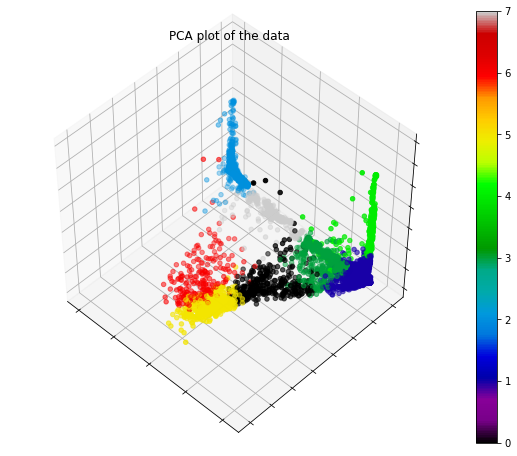

In [28]:
# plot PCA of clusters
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(data)
X = pca.transform(data)

# only needed for non int labels (I think)
# y = np.choose(label, [1, 2, 0]).astype(np.float)

pca_plot = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=label, cmap=plt.cm.spectral) # alt. cmap='spring'

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
fig.colorbar(pca_plot, ax=ax)

ax.set_title("PCA plot of the data")

### Interpret classification
Each cluster now represent specific behaviour throughout the night. To interpret this we use the definition by by Vincent T. van Hees et. al. [http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0142533](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0142533), that an angular movement less then 5° during a 5 minute period can be interpreted as sleep. The standard deviation of the resampled arm angle gives an understanding of how much the arm was moved during the resample interval. With labels from the clustering the data with label 2, 4 and 5
seem to identify an awake behaviour as seen in the figure below:

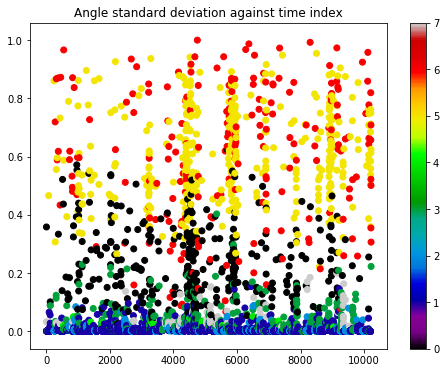

In [47]:
# scatter of labelled data (time index instead of timestamp to collect between days)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

dots = pd.DataFrame(data['angle std'].values)

scat_plot = ax.scatter(dots.index, dots.values, c=label, cmap=plt.cm.spectral)
ax.set_title('Angle standard deviation against time index')
fig.colorbar(scat_plot)

#### Simplfy the problem by merging some of the clusters together

In [20]:
# to reduce complexity of problem it is possible to merge clusters with similar features
# to more clearly distinguish specific features

def mergeCusters(label):
    label[label == 0] = 0
    label[label == 1] = 0
    label[label == 2] = 0
    label[label == 3] = 1
    label[label == 4] = 0
    label[label == 5] = 0
    label[label == 6] = 0
    label[label == 7] = 1
    return label

### Validating the model
To validate the model we use a dataset where we know the data represent an awake phase, and test that in our model. As seen in figure below, the majority of the test data is predicted as awake (4). The model may be improved with larger test set of labeled data.

In [85]:
# get awake data (assumed awake by analysing accelerometer data)
d = df[4]

# d[-5000:] extracts the data when the person is awake for a specific dataframe df[4]
[features, std, dd] = getFeatures(d[-5000:])

normFeat = norm(features)

testLabel = trainModel.predict(normFeat)

/Users/Andrew/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


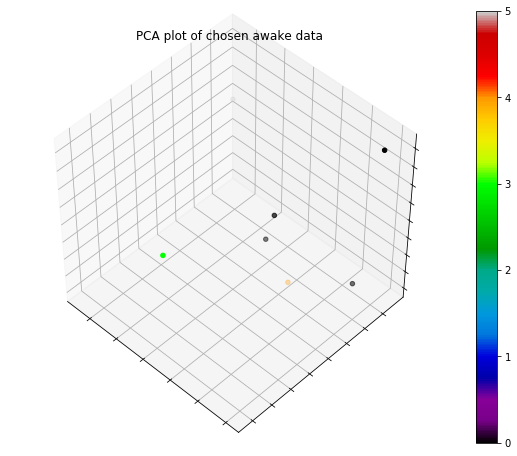

In [87]:
# plot PCA of clusters
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(normFeat)
X = pca.transform(normFeat)

# only needed for non int labels (I think)
# y = np.choose(label, [1, 2, 0]).astype(np.float)

pca_plot = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=testLabel, cmap=plt.cm.spectral) # alt. cmap='spring'

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
fig.colorbar(pca_plot, ax=ax)
ax.set_title("PCA plot of chosen awake data")

## Night quality assessment
To analyse the quality of a night, we need to compress the time series features into single values. Realised in similar fasion as the sleep detection by taking the four moments over the time series, and combining to a 1D array of features per night.

TODO: The timeseries themselves ought to be possible to use if 'Metric Learning' was to be implemented.

Features used for this classification are the raw sensor values. The initial approach was to use the extracted (resampled) features from the sleep classification, with data classified as awake removed to counteract bias. But to capture the complete behaviour during the night, this version focuses on using the entire nights sensor values. A more complete classification can be achieved by using the entire time series.

In [88]:
nightFeatures = []

for d in df:
    features = d[['light','noise','temperature','wearable-mag-xl1','wearable-xl1-x','wearable-xl1-y','wearable-xl1-z']] 
    feat = np.concatenate((features.mean(), features.std(), features.skew(), features.kurt()), axis=0)
    min_max_scalar = preprocessing.MinMaxScaler()
    normalise = min_max_scalar.fit_transform(feat)
    nightFeatures.append(normalise)

/Users/Andrew/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Andrew/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Andrew/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if

### Supervised learning

Using the sleep diaries provided, we can match the features of the environment and accelerometer through a night to a label provided by the diary entry of that night. The current implementation only consider the "Quality of Sleep" as label, converting the labels to numerics by 'Poor' = 0, 'Fair' = 1, 'Good' = 3 and 'Very good' = 4. 

The ideal implementation would be to use the features through the sleep detection as labels for the environmental/accelerometer data through a night. Our initial hypothesis was that the amount of REM sleep could be used as a quantitative way of measuring sleep quality. But this hypothesis was discouraged after reasearch suggested it as an inappropriate factor [http://healthysleep.med.harvard.edu/healthy/science/what/sleep-patterns-rem-nrem](http://healthysleep.med.harvard.edu/healthy/science/what/sleep-patterns-rem-nrem).

For the moment we are content in using the self assessed sleep quality from the sleep diaries.

#### loading the sleep diaries
Currently 'Sleep Data Research - ASD Morning.csv' must be found in (/irc-sphere-sleep-56db93f64661/Sphere-csv-data/) to be detected. Alter the path accordingly.

In [111]:
# load sleep diaries

path = find('Sleep Data Research - ASD Morning.csv','/irc-sphere-sleep-56db93f64661/Sphere-csv-data/')

if path is None:
    print("file not found, make sure your path is correct")
else:
    if 'gz' in path:
        fileName = path
        data = pd.read_csv(path, skiprows=1, index_col='Participant', compression='gzip')
    else: 
        data = pd.read_csv(path, skiprows=1, index_col='Participant')
data[:5]

,Date,Time in Bed,Time to Sleep,Time to fall asleep (minutes),Wake up time,Time to get up,Quality of Sleep,How Refreshed,Normal Night,Comments
Participant,,,,,,,,,,
1,01/06,23:00,23:30,5,07:00,07:00,Poor,Somewhat,Yes,-
1,02/06,23:30,00:00,5,06:30,06:30,Fair,Somewhat,Yes,-
1,03/06,23:00,23:30,5,07:00,07:00,Fair,Somewhat,Yes,-
14,20/04,23:00,23:10,60,08:20,08:25,Fair,Refreshed,No,woken by very noisy birds in the morning
14,21/04,22:30,23:00,60,07:55,08:00,Fair,Refreshed,No,Car alarm went off in the night


In [112]:
# convert 'Quality of Sleep' to numeric labels
allLabels = []
for d in data['Quality of Sleep']:
    if(d == 'Poor'):
        allLabels.append(0)
    elif(d == 'Fair'):
        allLabels.append(1)
    elif(d == 'Good'):
        allLabels.append(2)
    else:
        allLabels.append(3)

# get only labels for trainingData
labels = []
for i in range(len(allFeatures)):
    labels.append(allLabels[i])

### Cross validation

To assess the quality of our model we have to predict the label of testing data given training data. But since our test set is so small (only 9 nights with both sensor and diary data) we will use cross validation. We will remove one night and its label from the training data set to use as testing data, and train the KNN classifier on remaining nights, then use the model to predict the label of the testing night. Then systematically repeat this process for each of the nights.

In [113]:
predictions = []

for i,n in enumerate(nightFeatures):
    feature = np.delete(nightFeatures, i, axis=0)
    lbl = np.delete(labels, i)
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(feature, lbl)
    predict = knn.predict(nightFeatures[i])
    predictions.append(predict)

/Users/Andrew/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/Andrew/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/Andrew/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a singl

### Visualising true labels
The labels given by the sleep diaries

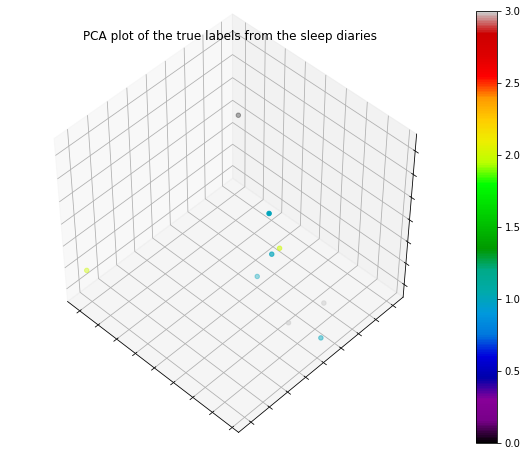

In [118]:
# make PCA (dimensionality reduction) to 3D and plot
# with TRUE labels

fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(nightFeatures)
X = pca.transform(nightFeatures)

# only needed for non int labels (I think)
# y = np.choose(label, [1, 2, 0]).astype(np.float)

pca_plot = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap=plt.cm.spectral) # alt. cmap='spring'
fig.colorbar(pca_plot, ax=ax)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_title("PCA plot of the true labels from the sleep diaries")

### Visualising predicted labels
The labels predicted by the model

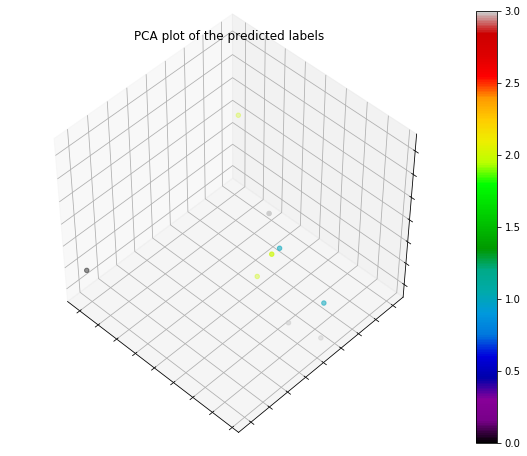

In [120]:
# make PCA (dimensionality reduction) to 3D and plot
# with PREDICTED labels
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(nightFeatures)
X = pca.transform(nightFeatures)

# only needed for non int labels (I think)
# y = np.choose(label, [1, 2, 0]).astype(np.float)

pca_plot = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=predictions, cmap=plt.cm.spectral) # alt. cmap='spring'
fig.colorbar(pca_plot, ax=ax)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_title("PCA plot of the predicted labels")

### Interpreting results
As we can see the predictor does not predict the labels very accurately. This seems to be due to the low amount of data, more data ought to improve the accuracy. 

## Ideal environment model
Considering the case where we are able to automatically identify good quality sleep and classify the sensor data of said night, we can build an environmental model based on that data. 

A nominal approach might be to consider the mean of the environmental data of all nights classified as 'Good' (or better) as a model. Future extensions could consider other types of environmental models or to weight more recent classifications higher etc. 

Even without the automatic quality classification, a future implementation might have a standard model for the environment - then only update the model based on manual feedback.

Anyways, this implementation simply takes the mean across multiple days as a demonstration.

In [124]:
# extract only interesting labels and resample to one minute
lbls = ['temperature', 'light', 'humidity']

for i,n in enumerate(lbls):
    dta = []
    for d in df:
        d.index = pd.DatetimeIndex(d.index)
        d1 = d.resample('1Min').mean()
        d1.dropna()
        dta.append(d1[lbls])

# remove the date from the timestamp in index
# to be able to compare data across days
for i, d in enumerate(dta):
    dta[i] = d.dropna()
    dta[i].index = dta[i].index.time

# get the latest time anyone goes to bed, and the earliest anyone wakes up    
evening_ind = []
morning_ind = []
for d in dta:
    evening_ind.append(d.index[0])
    morning_ind.append(d.index[-1])

# remove data times where not everyone are in bed
for i,d in enumerate(dta):
    for ind, val in enumerate(d.index):
        if(val < max(evening_ind) and val > max(morning_ind)):
            dta[i] = dta[i].drop([val])
        elif(val > min(morning_ind) and val < min(evening_ind)):
            dta[i] = dta[i].drop([val])

# calculate the mean of the features
# could also use min/max/moments, etc.
# here we use all days available, but should be extended to only use data from 
# specific days, e.g. classified as good
features = sum(dta) / len(dta)

The jump in the plots are due to plotting in time domain, and the first part of the night is belonging to previous night

#### Only the people in Sphere who collected are aware of the unit of measurements, so the plots do not have labels for the y-axis

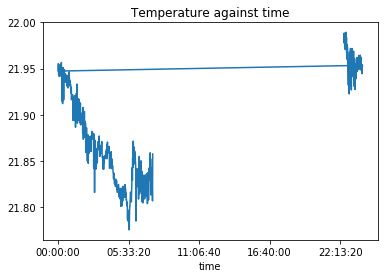

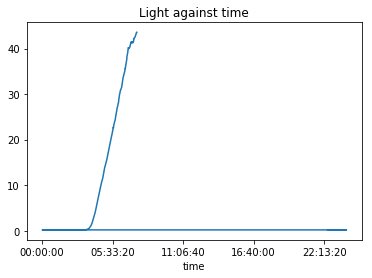

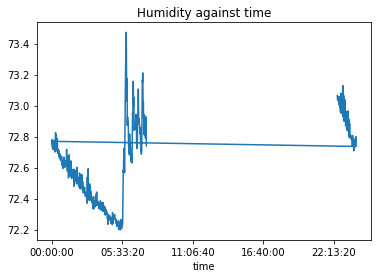

In [128]:
plt.figure(1)
plt.title('Temperature against time')
plt.plot(features.index, features['temperature'])

plt.figure(2)
plt.title('Light against time')
plt.plot(features.index, features['light'])

plt.figure(3)
plt.title('Humidity against time')
plt.plot(features.index, features['humidity'])